## 📊 Dataset (Kaggle)
Este notebook utiliza o conjunto **Daily Climate time series data** do Kaggle, que contém os arquivos `DailyDelhiClimateTrain.csv` e `DailyDelhiClimateTest.csv`.

**Link do dataset:** https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

> Observação: o link acima aponta para a página oficial do dataset no Kaggle. Os dois arquivos usados no notebook estão disponíveis nesta página.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 15.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Para visualização
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sktime e Prophet
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sktime.utils.plotting import plot_series
from prophet import Prophet

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Para avaliação do modelo
from math import sqrt

# Configurando o estilo dos gráficos
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")

In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/ponderada_lstm_temporal/DailyDelhiClimateTrain.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ponderada_lstm_temporal/DailyDelhiClimateTest.csv')

print("Primeiras linhas dos dados de treino:")
display(train_data.head())

print("\nPrimeiras linhas dos dados de teste:")
display(test_data.head())

Primeiras linhas dos dados de treino:


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000



Primeiras linhas dos dados de teste:


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [6]:
# 2. Exploração dos dados

print("\nInformações dos dados de treino:")
display(train_data.info())

print("\nEstatísticas descritivas dos dados de treino:")
display(train_data.describe())

print("\nValores nulos nos dados de treino:")
display(train_data.isnull().sum())

print("\nValores nulos nos dados de teste:")
display(test_data.isnull().sum())


Informações dos dados de treino:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


None


Estatísticas descritivas dos dados de treino:


,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333



Valores nulos nos dados de treino:


,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0



Valores nulos nos dados de teste:


,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [7]:
# 3. Pré-processamento dos dados

# Convertendo a coluna de data para datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Definindo a coluna de data como índice
train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

# Verificando se há valores duplicados no índice
print("\nValores duplicados no índice de treino:", train_data.index.duplicated().sum())
print("Valores duplicados no índice de teste:", test_data.index.duplicated().sum())

# Removendo duplicatas, se houver
train_data = train_data[~train_data.index.duplicated()]
test_data = test_data[~test_data.index.duplicated()]

# Verificando valores ausentes e preenchendo-os
if train_data.isnull().sum().sum() > 0:
    print("\nPreenchendo valores ausentes...")
    train_data = train_data.interpolate(method='time')

if test_data.isnull().sum().sum() > 0:
    test_data = test_data.interpolate(method='time')

# Verificando novamente os valores nulos após o processamento
print("\nValores nulos após processamento:")
print("Treino:", train_data.isnull().sum().sum())
print("Teste:", test_data.isnull().sum().sum())


Valores duplicados no índice de treino: 0
Valores duplicados no índice de teste: 0

Valores nulos após processamento:
Treino: 0
Teste: 0


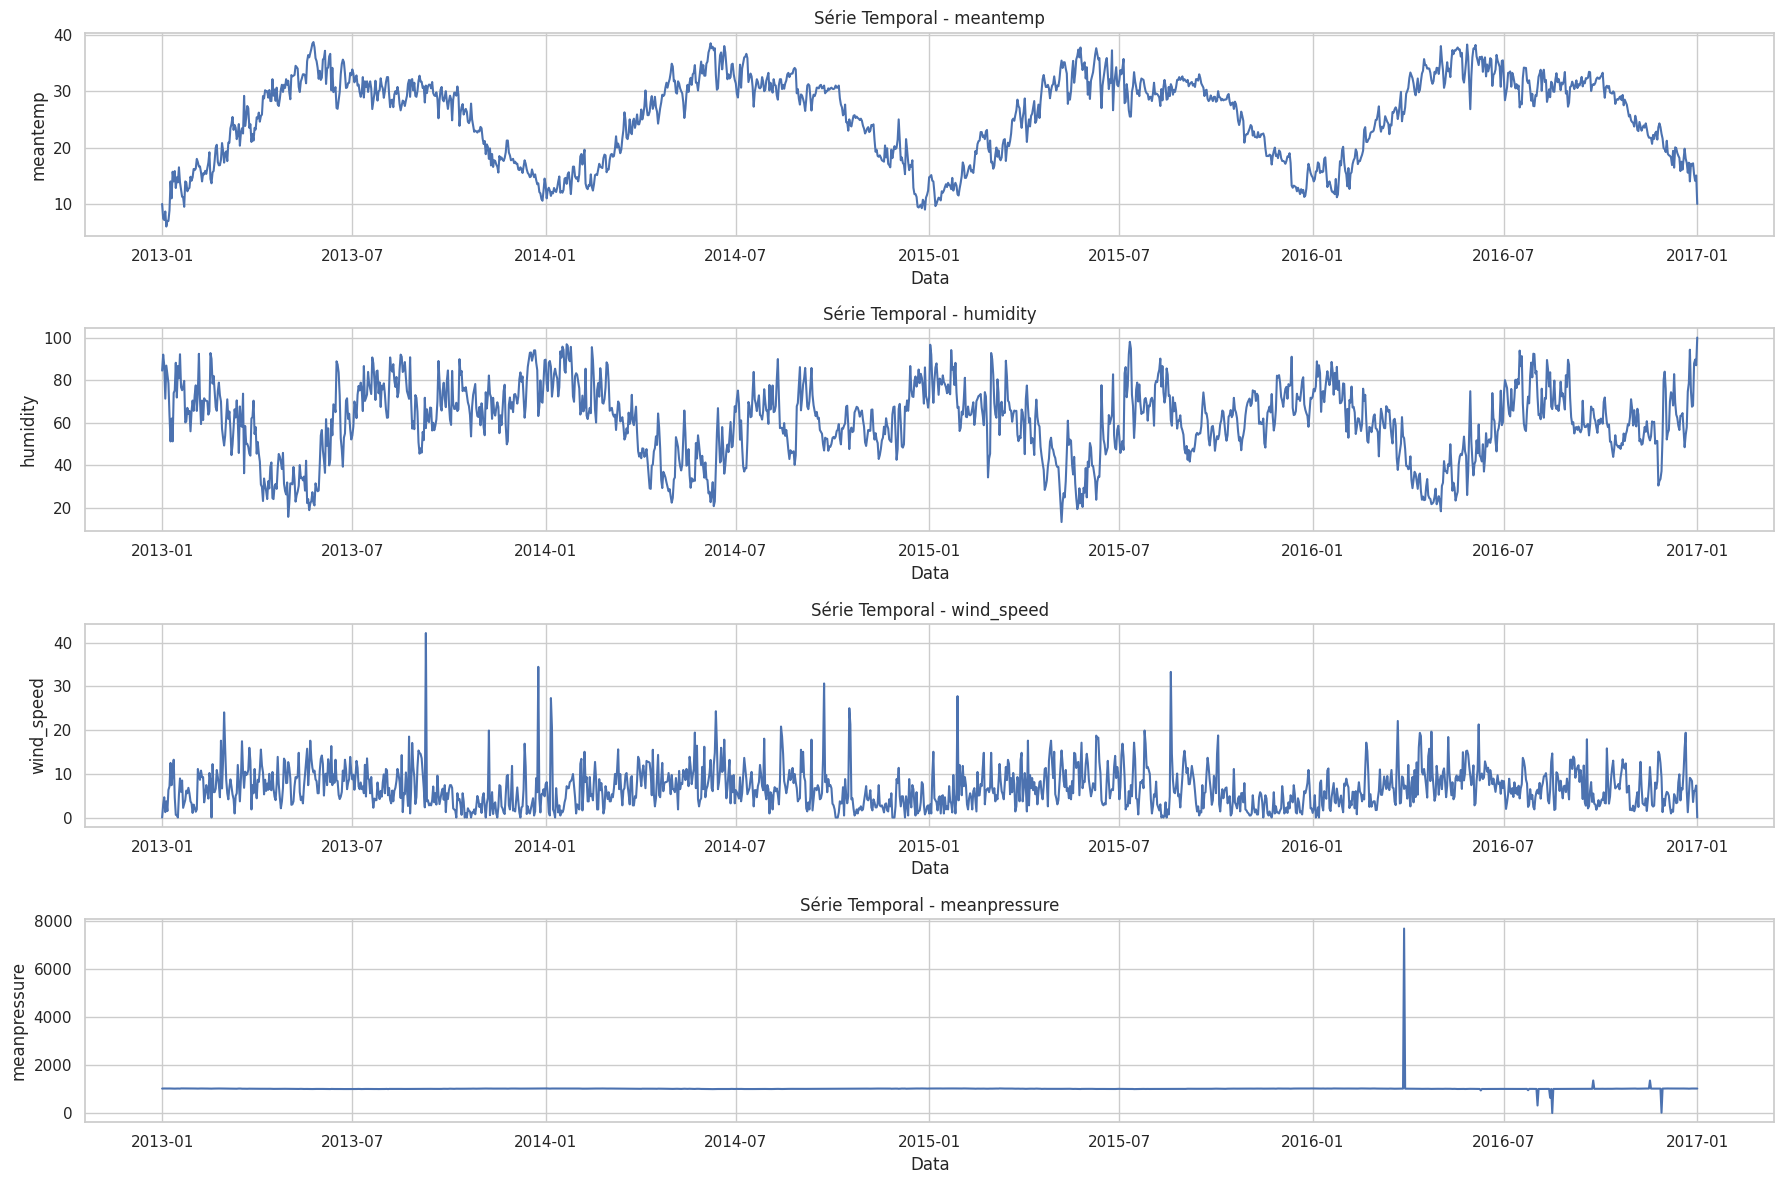

<Figure size 1500x1000 with 0 Axes>

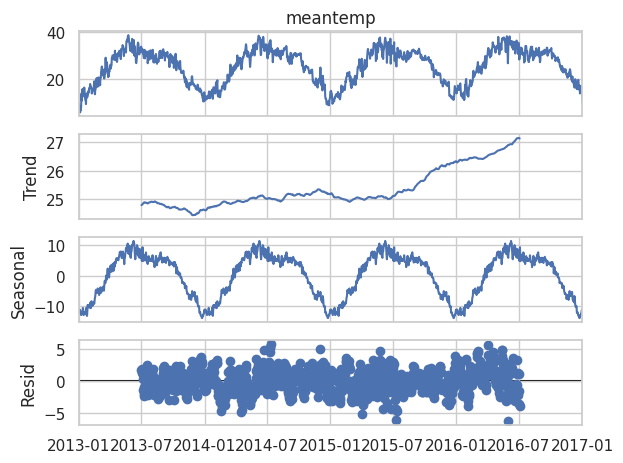

In [8]:
# 4. Análise visual da série temporal

# Definindo as variáveis de interesse
variables = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

# Criando gráficos das séries temporais para as variáveis
plt.figure(figsize=(18, 12))

for i, var in enumerate(variables, 1):
    plt.subplot(len(variables), 1, i)
    plt.plot(train_data.index, train_data[var])
    plt.title(f'Série Temporal - {var}')
    plt.xlabel('Data')
    plt.ylabel(var)
    plt.grid(True)

plt.tight_layout()
plt.show()

# Analisando a sazonalidade e tendência (usando meantemp como exemplo)
# Decomposição da série temporal
from statsmodels.tsa.seasonal import seasonal_decompose

# Escolhendo 'meantemp' como exemplo
plt.figure(figsize=(15, 10))
decomposition = seasonal_decompose(train_data['meantemp'], model='additive', period=365)
decomposition.plot()
plt.tight_layout()
plt.show()

In [9]:
# 5. Implementação com Prophet

# Função para treinar e avaliar o modelo Prophet
def run_prophet_model(train, test, target_variable):
    # 'ds' para datetime e 'y' para a variável alvo
    prophet_train = train.reset_index()
    prophet_train = prophet_train.rename(columns={'date': 'ds', target_variable: 'y'})

    prophet_test = test.reset_index()
    prophet_test = prophet_test.rename(columns={'date': 'ds', target_variable: 'y'})

    # Criando e treinando o modelo
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
    model.fit(prophet_train[['ds', 'y']])

    # Criando um dataframe para previsão
    future = prophet_test[['ds']].copy()

    # Realizando previsões
    forecast = model.predict(future)

    # Extraindo as previsões
    y_pred = forecast['yhat'].values
    y_true = prophet_test['y'].values

    # Calculando métricas de erro
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Criando um dataframe com resultados
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    results.index = prophet_test['ds']

    return model, forecast, results, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dmgm21l/0g7229bo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dmgm21l/0tu4j6pm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16675', 'data', 'file=/tmp/tmp1dmgm21l/0g7229bo.json', 'init=/tmp/tmp1dmgm21l/0tu4j6pm.json', 'output', 'file=/tmp/tmp1dmgm21l/prophet_model_tiq9iy5/prophet_model-20250330123738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:37:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:37:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


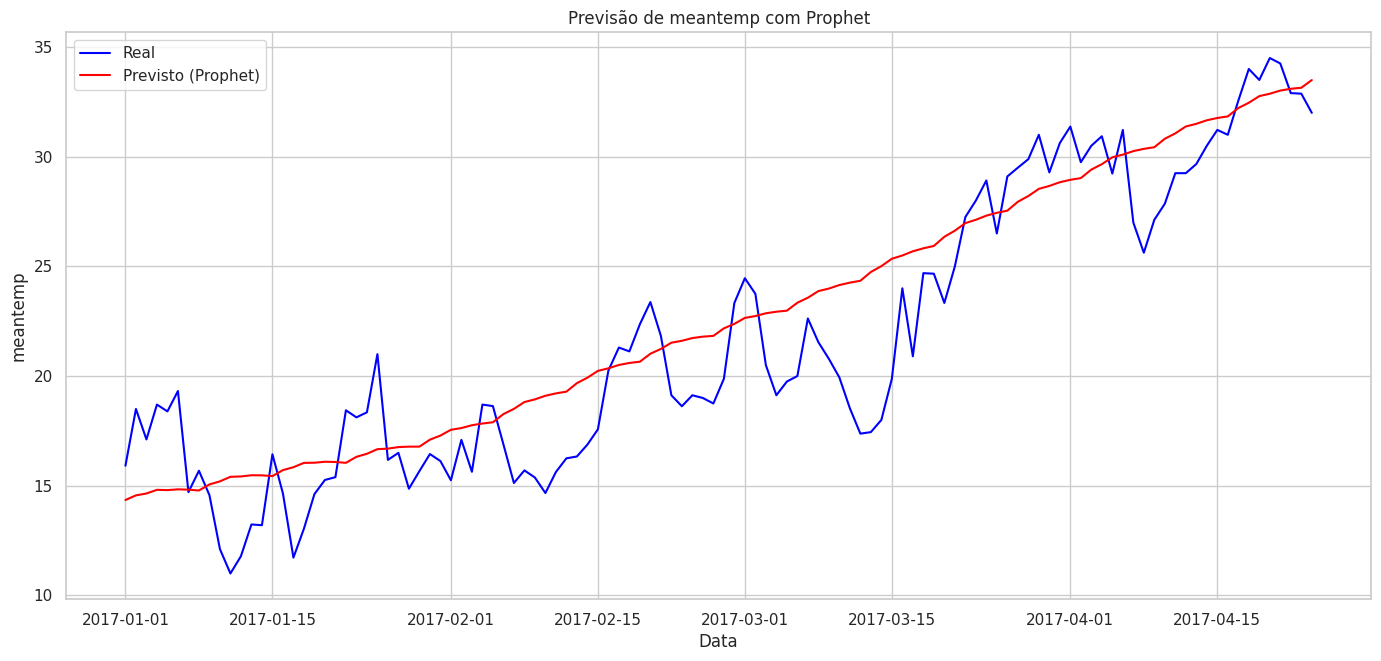


Métricas de avaliação do Prophet:
MSE: 7.094828632630564
RMSE: 2.6636119523366317
MAE: 2.187801761181909
MAPE: 0.11617821324524277
R2: 0.8230525639150409


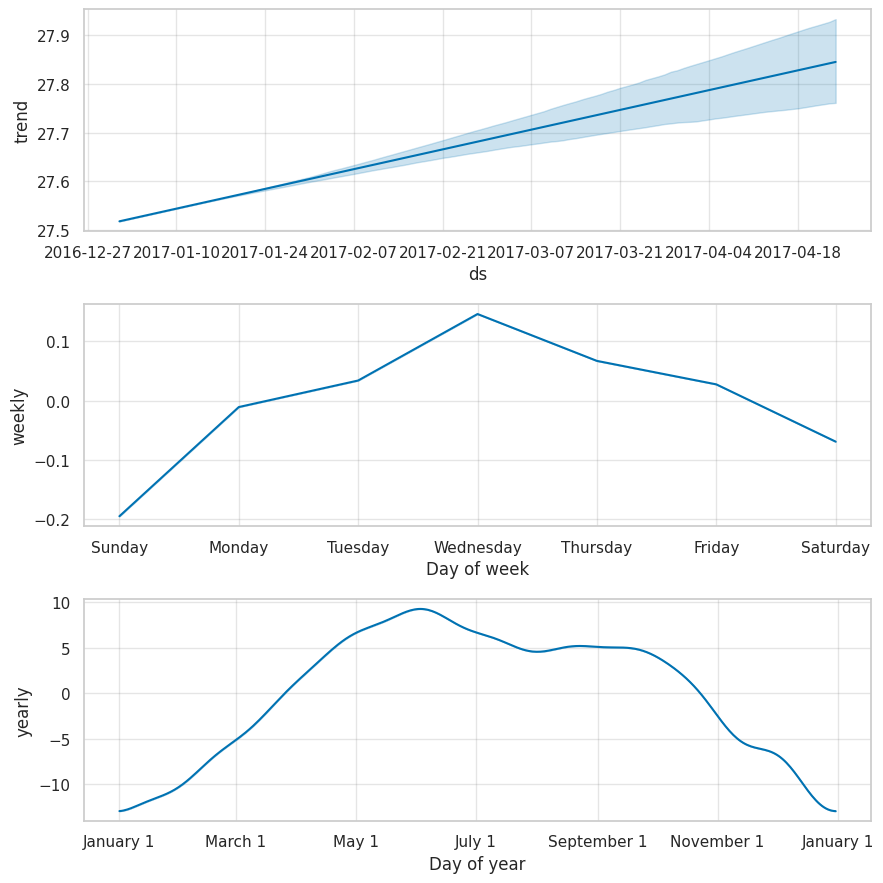

In [10]:
# Aplicando o modelo Prophet para a temperatura média
target_var = 'meantemp'
prophet_model, prophet_forecast, prophet_results, prophet_metrics = run_prophet_model(train_data, test_data, target_var)

# Visualizando os resultados da previsão do Prophet
plt.figure(figsize=(15, 7))
plt.plot(prophet_results.index, prophet_results['y_true'], label='Real', color='blue')
plt.plot(prophet_results.index, prophet_results['y_pred'], label='Previsto (Prophet)', color='red')
plt.title(f'Previsão de {target_var} com Prophet')
plt.xlabel('Data')
plt.ylabel(target_var)
plt.legend()
plt.grid(True)
plt.show()

# Imprimindo as métricas do Prophet
print("\nMétricas de avaliação do Prophet:")
for metric, value in prophet_metrics.items():
    print(f"{metric}: {value}")

# Plotando os componentes da previsão do Prophet
prophet_model.plot_components(prophet_forecast)
plt.show()

In [11]:
# 6. Implementação com LSTM

# Preparando os dados para o LSTM
def create_sequences(data, target_col_idx, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, target_col_idx])
    return np.array(X), np.array(y)

# Função para treinar e avaliar o modelo LSTM
def run_lstm_model(train, test, target_variable, n_steps=7):
    data_combined = pd.concat([train, test])
    feature_columns = data_combined.columns.tolist()

    # Identificando o índice da coluna alvo
    target_col_idx = feature_columns.index(target_variable)

    # Normalizando os dados
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_combined)

    # Recriando os dataframes com os dados normalizados
    train_scaled = pd.DataFrame(data_scaled[:len(train)], columns=feature_columns, index=train.index)
    test_scaled = pd.DataFrame(data_scaled[len(train):], columns=feature_columns, index=test.index)

    train_array = train_scaled.values
    test_array = test_scaled.values

    # Criando sequências para LSTM
    X_train, y_train = create_sequences(train_array, target_col_idx, n_steps)
    X_test, y_test = create_sequences(test_array, target_col_idx, n_steps)

    # Definindo o índice correto para os resultados de teste
    test_indices = test_scaled.index[n_steps:]

    # Verificando as dimensões dos dados
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Definindo a arquitetura do modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Compilando o modelo
    model.compile(optimizer='adam', loss='mse')

    # Definindo early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Treinando o modelo
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    # Realizando previsões
    y_pred_scaled = model.predict(X_test)

    # Preparando para desnormalizar as previsões
    dummy = np.zeros((len(y_pred_scaled), len(feature_columns)))
    dummy[:, target_col_idx] = y_pred_scaled.flatten()

    # Desnormalizando as previsões
    y_pred = scaler.inverse_transform(dummy)[:, target_col_idx]

    # Preparando para desnormalizar os valores reais
    dummy = np.zeros((len(y_test), len(feature_columns)))
    dummy[:, target_col_idx] = y_test

    # Desnormalizando os valores reais
    y_true = scaler.inverse_transform(dummy)[:, target_col_idx]

    # Calculando métricas de erro
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Calculando MAPE manualmente
    r2 = r2_score(y_true, y_pred)

    # Criando um dataframe com resultados
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    results.index = test_indices

    return model, history, results, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

X_train shape: (1455, 7, 4)
y_train shape: (1455,)
X_test shape: (107, 7, 4)
y_test shape: (107,)
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2232 - val_loss: 0.0359
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209 - val_loss: 0.0059
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - val_loss: 0.0047
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - val_loss: 0.0045
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - val_loss: 0.0047
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - val_loss: 0.0063
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - val_loss: 0.0048
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0045
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - val_loss: 0.0046
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

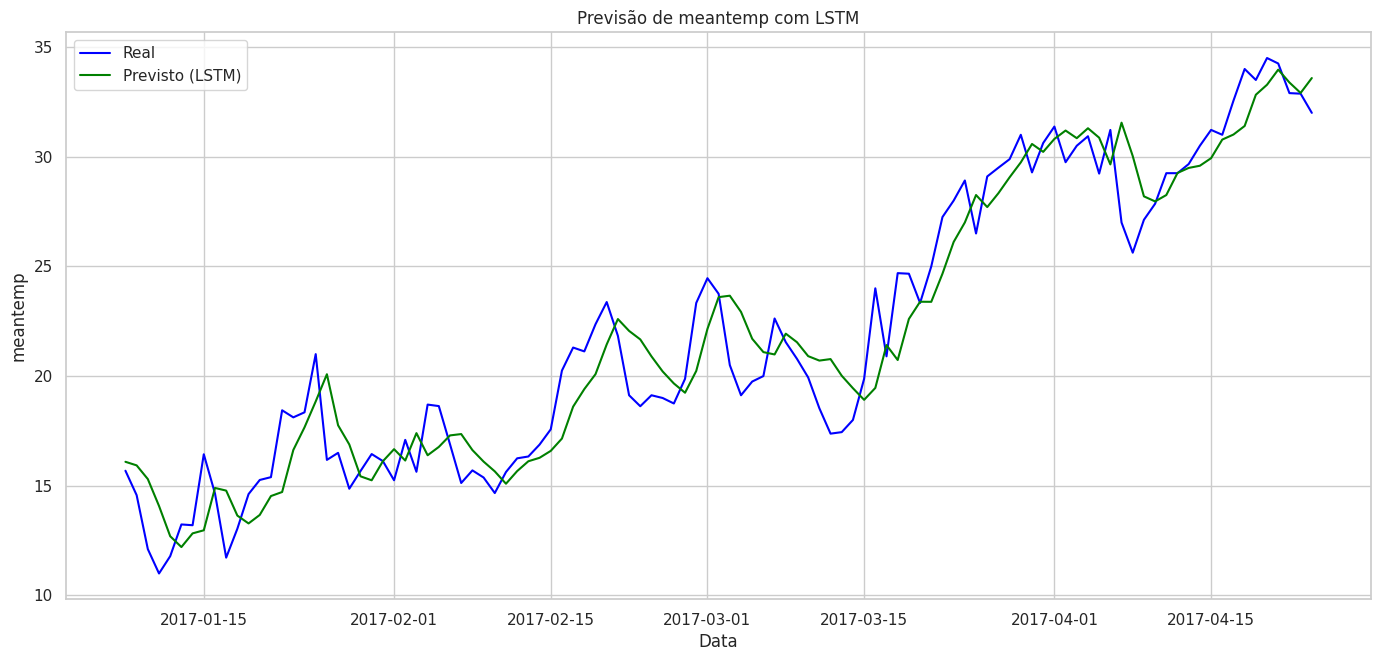


Métricas de avaliação do LSTM:
MSE: 3.5564147099093772
RMSE: 1.885845887104611
MAE: 1.5218716760859565
MAPE: 7.6859204785692565
R2: 0.9139599724005628


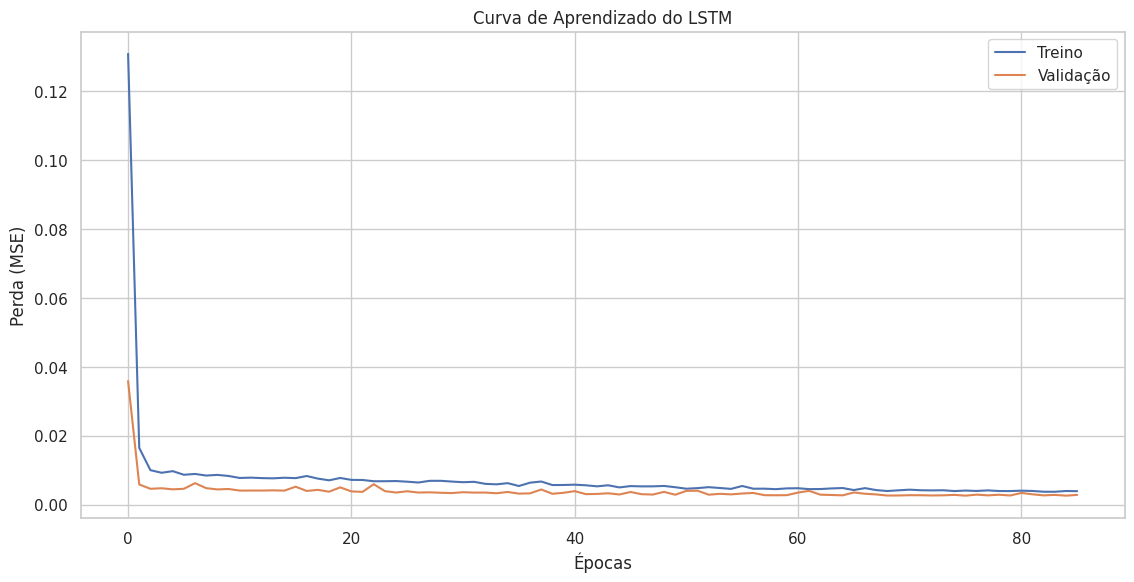

In [12]:
# Aplicando o modelo LSTM para a temperatura média
lstm_model, lstm_history, lstm_results, lstm_metrics = run_lstm_model(train_data, test_data, target_var)

# Visualizando os resultados da previsão do LSTM
plt.figure(figsize=(15, 7))
plt.plot(lstm_results.index, lstm_results['y_true'], label='Real', color='blue')
plt.plot(lstm_results.index, lstm_results['y_pred'], label='Previsto (LSTM)', color='green')
plt.title(f'Previsão de {target_var} com LSTM')
plt.xlabel('Data')
plt.ylabel(target_var)
plt.legend()
plt.grid(True)
plt.show()

# Imprimindo as métricas do LSTM
print("\nMétricas de avaliação do LSTM:")
for metric, value in lstm_metrics.items():
    print(f"{metric}: {value}")

# Plotando a curva de aprendizado do LSTM
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Treino')
plt.plot(lstm_history.history['val_loss'], label='Validação')
plt.title('Curva de Aprendizado do LSTM')
plt.xlabel('Épocas')
plt.ylabel('Perda (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# 7. Comparação dos modelos

# Criando um dataframe com os resultados dos dois modelos
comparison_df = pd.DataFrame({
    'Prophet': [prophet_metrics['MSE'], prophet_metrics['RMSE'], prophet_metrics['MAE'],
               prophet_metrics['MAPE'], prophet_metrics['R2']],
    'LSTM': [lstm_metrics['MSE'], lstm_metrics['RMSE'], lstm_metrics['MAE'],
            lstm_metrics['MAPE'], lstm_metrics['R2']]
}, index=['MSE', 'RMSE', 'MAE', 'MAPE', 'R2'])

print("\nComparação das métricas dos modelos:")
display(comparison_df)


Comparação das métricas dos modelos:


,Prophet,LSTM
MSE,7.094829,3.556415
RMSE,2.663612,1.885846
MAE,2.187802,1.521872
MAPE,0.116178,7.685920
R2,0.823053,0.913960


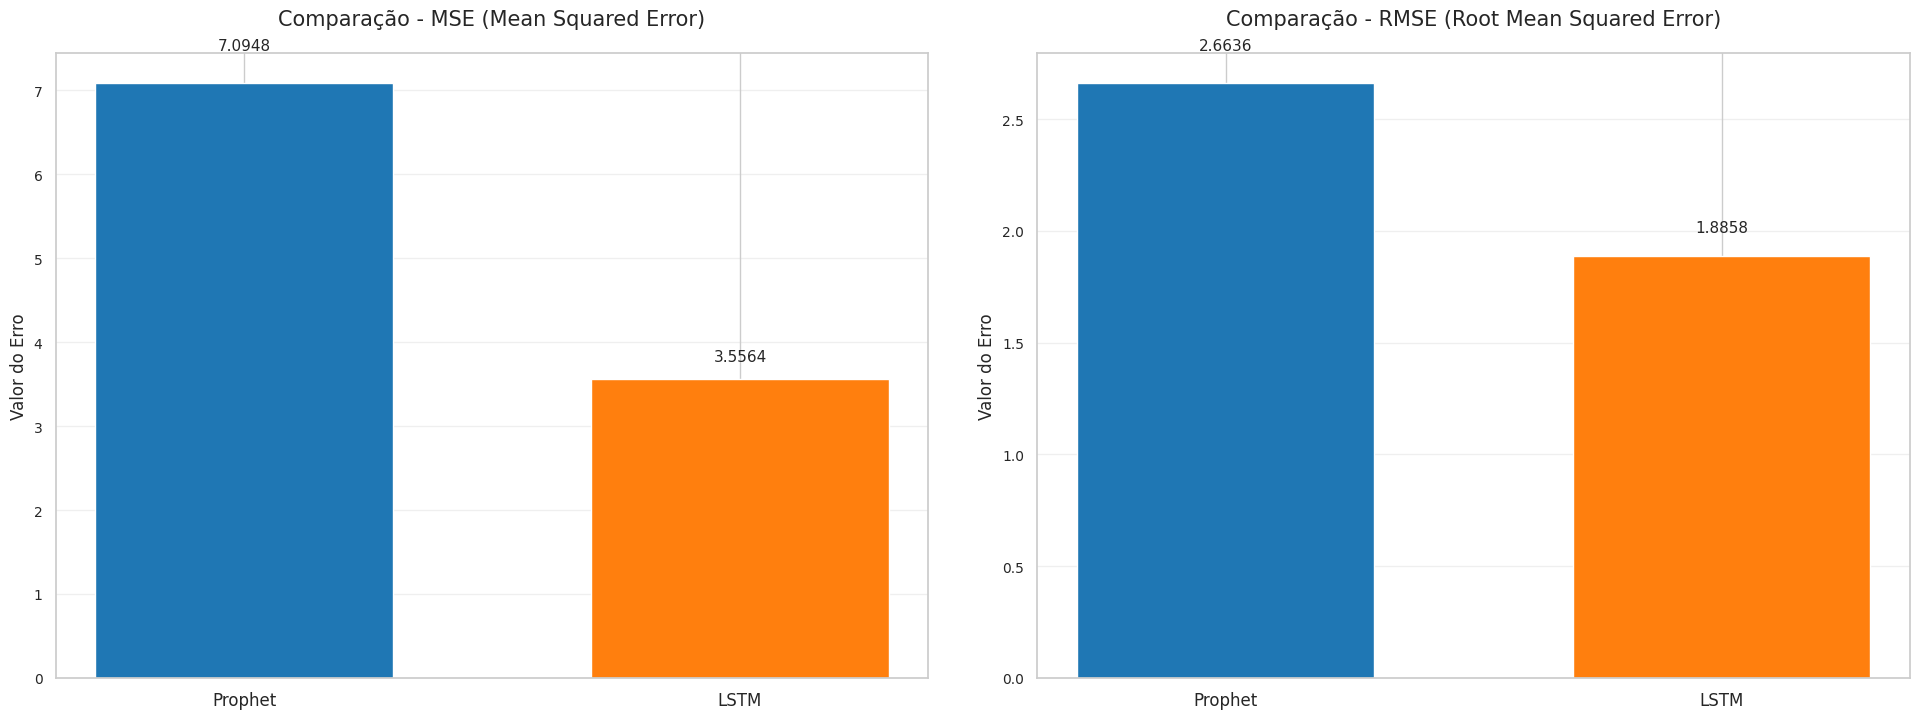

In [19]:
# Visualizando a comparação das métricas MSE e RMSE
plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.3)

# MSE
plt.subplot(1, 2, 1)
bars1 = plt.bar(['Prophet', 'LSTM'], [comparison_df.loc['MSE', 'Prophet'], comparison_df.loc['MSE', 'LSTM']],
       color=['#1f77b4', '#ff7f0e'], width=0.6)
plt.title('Comparação - MSE (Mean Squared Error)', fontsize=15, pad=20)
plt.ylabel('Valor do Erro', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05*height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=11)

# RMSE
plt.subplot(1, 2, 2)
bars2 = plt.bar(['Prophet', 'LSTM'], [comparison_df.loc['RMSE', 'Prophet'], comparison_df.loc['RMSE', 'LSTM']],
       color=['#1f77b4', '#ff7f0e'], width=0.6)
plt.title('Comparação - RMSE (Root Mean Squared Error)', fontsize=15, pad=20)
plt.ylabel('Valor do Erro', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05*height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout(pad=3.0)
plt.show()

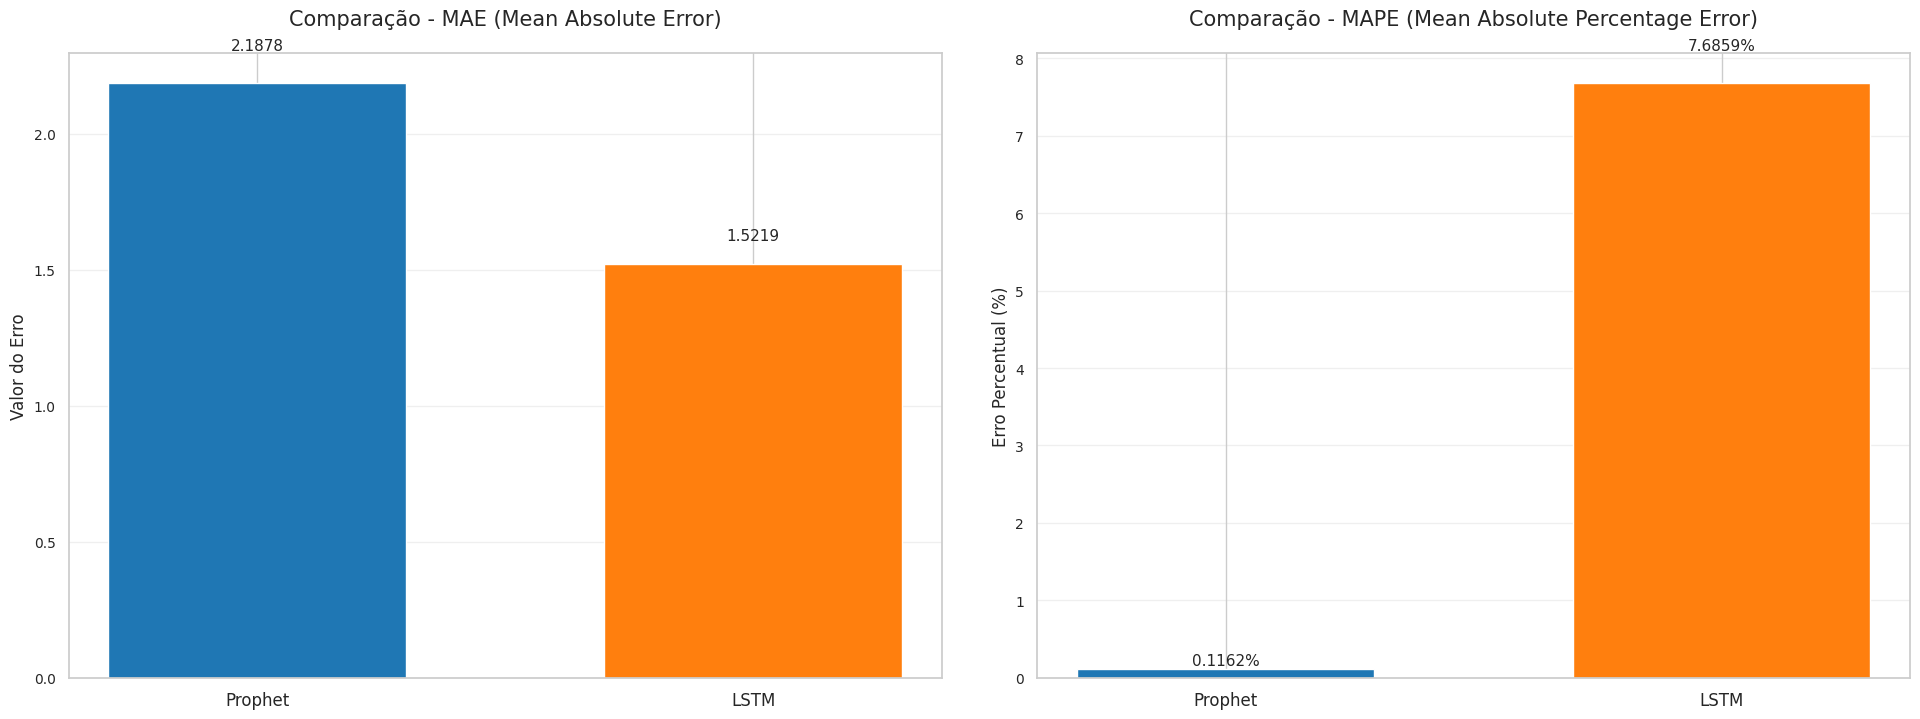

In [18]:
plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.3)

# MAE
plt.subplot(1, 2, 1)
bars3 = plt.bar(['Prophet', 'LSTM'], [comparison_df.loc['MAE', 'Prophet'], comparison_df.loc['MAE', 'LSTM']],
       color=['#1f77b4', '#ff7f0e'], width=0.6)
plt.title('Comparação - MAE (Mean Absolute Error)', fontsize=15, pad=20)
plt.ylabel('Valor do Erro', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05*height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=11)

# MAPE
plt.subplot(1, 2, 2)
bars4 = plt.bar(['Prophet', 'LSTM'], [comparison_df.loc['MAPE', 'Prophet'], comparison_df.loc['MAPE', 'LSTM']],
       color=['#1f77b4', '#ff7f0e'], width=0.6)
plt.title('Comparação - MAPE (Mean Absolute Percentage Error)', fontsize=15, pad=20)
plt.ylabel('Erro Percentual (%)', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
for bar in bars4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05*height,
            f'{height:.4f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout(pad=3.0)
plt.show()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

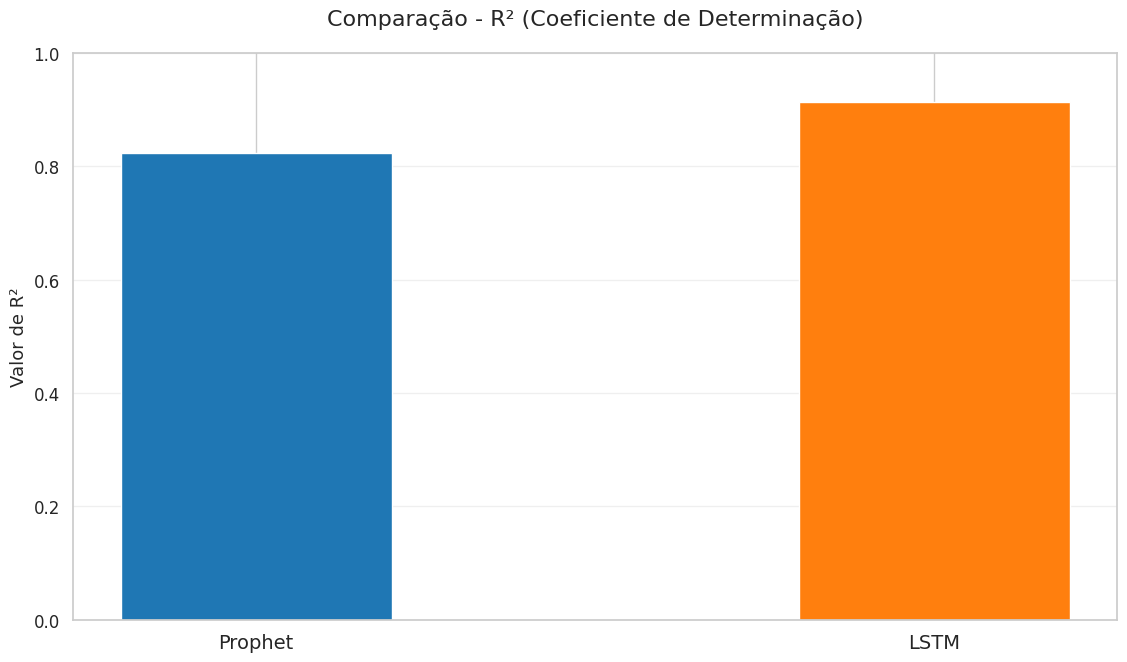

In [20]:
plt.figure(figsize=(12, 7))
bars5 = plt.bar(['Prophet', 'LSTM'], [comparison_df.loc['R2', 'Prophet'], comparison_df.loc['R2', 'LSTM']],
       color=['#1f77b4', '#ff7f0e'], width=0.4)
plt.title('Comparação - R² (Coeficiente de Determinação)', fontsize=16, pad=20)
plt.ylabel('Valor de R²', fontsize=13)
plt.ylim(0, 1.0)  # R² geralmente está entre 0 e 1
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

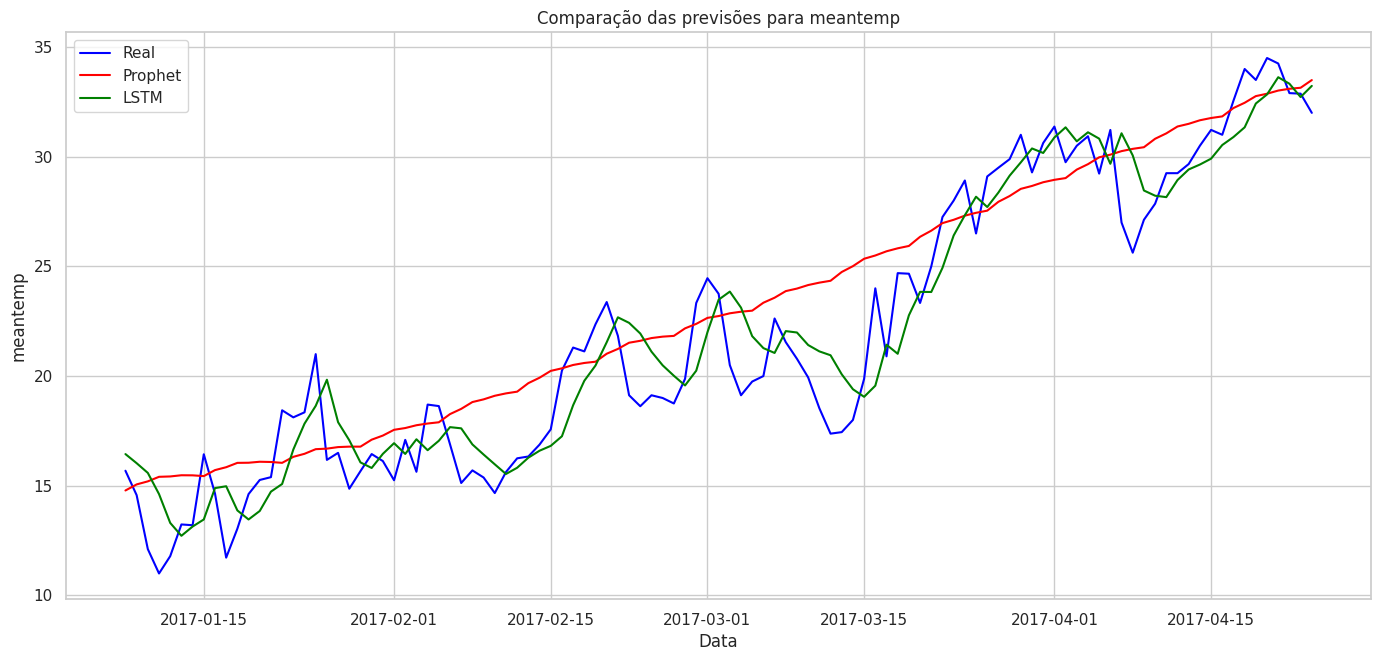

In [33]:
# 8. Visualização conjunta das previsões

# Combinando as previsões em um único dataframe para o período de teste
common_indices = lstm_results.index.intersection(prophet_results.index)
combined_results = pd.DataFrame({
    'Real': lstm_results.loc[common_indices, 'y_true'],
    'Prophet': prophet_results.loc[common_indices, 'y_pred'],
    'LSTM': lstm_results.loc[common_indices, 'y_pred']
})

# Plotando as previsões combinadas
plt.figure(figsize=(15, 7))
plt.plot(combined_results.index, combined_results['Real'], label='Real', color='blue')
plt.plot(combined_results.index, combined_results['Prophet'], label='Prophet', color='red')
plt.plot(combined_results.index, combined_results['LSTM'], label='LSTM', color='green')
plt.title(f'Comparação das previsões para {target_var}')
plt.xlabel('Data')
plt.ylabel(target_var)
plt.legend()
plt.grid(True)
plt.show()
